In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import pandas as pd
from scipy.stats import truncnorm

In [2]:
np.random.seed(0)
def get_surgery_time(mean,std):
    #sh,sc = (mean/std)**2,std**2/mean
    #return np.random.gamma(shape=sh,scale=sc)
    return truncnorm.rvs(-1,1,loc=mean,scale=std)

In [3]:
#problem parameters
specs = ['CARD','GASTRO','GYN','MED','ORTHO','URO']

surgery_data = {'CARD':[99.0,53.0],'GASTRO':[132.0,76.0],'GYN':[78.0,52.0],'MED':[75.0,32.0],'ORTHO':[142.0,58.0],'URO':[72.0,38.0]}

blocks = {'CARD':[2,6,16,28,32,33],'GASTRO':[1,8,14,15,22,27,34],'GYN':[4,11,12,18,19,24,25,30,35],'MED':[17,36],'ORTHO':[3,9,10,21,23,29,37],'URO':[5,7,13,20,26,31,38]}
block_len = [8*60.0 for i in range(32)]+[100*60.0 for i in range(len(specs))]
n_blocks = len(block_len)

n_surgeries = 100
percent_surg = {'CARD':14,'GASTRO':18,'GYN':28,'MED':5,'ORTHO':17,'URO':18}
surgeries = {}
tot = 0
for i in specs[:len(specs)-1]:
    surgeries[i] = round(n_surgeries*percent_surg[i]/100.0)
    tot += surgeries[i]
surgeries[specs[-1]] = n_surgeries-tot

surgery_nums = {}
t = 0
for s in specs:
    surgery_nums[s] = [t,t+surgeries[s]-1]
    t = t+surgeries[s]
    
print(surgeries)
print(surgery_nums)

{'CARD': 14, 'GASTRO': 18, 'GYN': 28, 'MED': 5, 'ORTHO': 17, 'URO': 18}
{'CARD': [0, 13], 'GASTRO': [14, 31], 'GYN': [32, 59], 'MED': [60, 64], 'ORTHO': [65, 81], 'URO': [82, 99]}


In [4]:
np.random.seed(0)
cib = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]) # block costs
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]):
        #costs = sorted([np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)])
        costs = [np.random.randint(low=1,high=5)*100 for _ in range(len(blocks[s])-1)]
        f = 0
        for b in blocks[s][:len(blocks[s])-1]:
            cib[i,b-1] = costs[f]
            f += 1
            
        
dummy_cost = 1000
for s in specs:
    for i in range(surgery_nums[s][0],surgery_nums[s][1]+1):
        b = blocks[s][-1]
        cib[i,b-1] = dummy_cost

cob = np.array([5.0 for _ in range(n_blocks)])
cgb = np.array([5.0/1.5 for _ in range(n_blocks-len(specs))]+[0.0 for _ in range(len(specs))])

In [5]:
#block and surgery of a speciality fesibility
p = [[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)]
p = np.array(p)
t = 0
for s in specs:
    for i in range(surgeries[s]):
        for b in blocks[s]:
            p[t,b-1] = 1.0
        t += 1

In [6]:
print(p[9,:])

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


In [7]:
n_scenarios = 1000
avg_model = ConcreteModel()
avg_model.y = Var(RangeSet(n_surgeries),RangeSet(n_blocks),domain=Binary)
avg_model.o = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals,bounds=(0,120))
avg_model.g = Var(RangeSet(n_blocks),RangeSet(n_scenarios),domain=NonNegativeReals)

avg_model.atmost1 = ConstraintList()
for i in range(n_surgeries):
    avg_model.atmost1.add(expr=sum(avg_model.y[i+1,b] for b in range(1,n_blocks+1))==1)

avg_model.specfeas = ConstraintList()
for i in range(n_surgeries):
    for b in range(n_blocks):
        avg_model.specfeas.add(expr=avg_model.y[i+1,b+1] <= p[i,b])

avg_model.ogcons = ConstraintList()
for n in range(n_scenarios):
    t = 0
    for s in specs:
        for b in blocks[s]:
            avg_model.ogcons.add(expr=avg_model.o[b,n+1]-avg_model.g[b,n+1] == sum(get_surgery_time(surgery_data[s][0],surgery_data[s][1])*avg_model.y[i+1,b] for i in range(surgery_nums[s][0],surgery_nums[s][1]+1))-block_len[b-1])
'''
avg_model.atleast1inblock = ConstraintList()
for b in range(n_blocks-len(specs)):
    avg_model.atleast1inblock.add(expr=sum(avg_model.y[i+1,b+1] for i in range(n_surgeries))>=1.0)
'''
avg_model.cost = Objective(expr=sum(sum(avg_model.y[i+1,b+1]*cib[i,b] for i in range(n_surgeries)) for b in range(n_blocks))+(sum(cob[b]*avg_model.o[b+1,n+1]+cgb[b]*avg_model.g[b+1,n+1] for b in range(n_blocks) for n in range(n_scenarios)))/n_scenarios,sense=minimize)

In [8]:
opt = SolverFactory('cplex')
opt.options['timelimit'] = 60
result = opt.solve(avg_model,tee=True)
print("Solver status :",result.solver.status)
print("Solver Termination condition :", result.solver.termination_condition)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\91824\AppData\Local\Temp\tmpmjfln8va.cplex.log' open.
CPLEX> New value for time limit in seconds: 60
CPLEX> Problem 'C:\Users\91824\AppData\Local\Temp\tmpunu69i5h.pyomo.lp' read.
Read time = 0.52 sec. (14.78 ticks)
CPLEX> Problem name         : C:\Users\91824\AppData\Local\Temp\tmpunu69i5h.pyomo.lp
Objective sense      : Minimize
Variables            :   79801  [Nneg: 38001,  Box: 38000,  Binary: 3800]
Objective nonzeros   :   70685
Linear constraints   :   41901  [Less: 3800,  Equal: 38101]
  Nonzeros           :  800601
  RHS nonzeros       :   38818

Variables            : Min LB: 

In [9]:
#pd.DataFrame(cib).to_csv("cost_data_random_seed0.csv")

In [10]:
l = [[] for _ in range(n_blocks)]
for b in range(n_blocks):
    for i in range(n_surgeries):
        if avg_model.y[i+1,b+1].value > 0.0:
            l[b].append(i)

for i in range(len(l)):
    print("Block :",i+1, 'Surgeries',l[i])
    

Block : 1 Surgeries [14, 16, 17, 18, 19, 22, 30]
Block : 2 Surgeries [9, 10, 11]
Block : 3 Surgeries [65, 66, 73]
Block : 4 Surgeries [36, 42, 44, 49]
Block : 5 Surgeries [94, 95, 96]
Block : 6 Surgeries [3, 6]
Block : 7 Surgeries [85, 87, 91, 98]
Block : 8 Surgeries [20, 22, 28, 31]
Block : 9 Surgeries [68, 72, 76]
Block : 10 Surgeries [74, 75, 81]
Block : 11 Surgeries [41, 50, 54, 59]
Block : 12 Surgeries [32, 33, 37]
Block : 13 Surgeries [90]
Block : 14 Surgeries [14, 26, 27, 30]
Block : 15 Surgeries [14, 15, 17, 18, 25, 31]
Block : 16 Surgeries [2, 8, 13]
Block : 17 Surgeries [60, 61, 62, 63, 64]
Block : 18 Surgeries [35, 38, 39, 40]
Block : 19 Surgeries [43, 46, 57]
Block : 20 Surgeries [82, 83, 84, 88, 89]
Block : 21 Surgeries [69, 77]
Block : 22 Surgeries [17, 18, 19, 21, 29, 31]
Block : 23 Surgeries [67, 71, 79]
Block : 24 Surgeries [34, 52, 55]
Block : 25 Surgeries [45, 48, 53, 58]
Block : 26 Surgeries [86, 92, 93, 99]
Block : 27 Surgeries [16, 20, 21, 23, 24, 31]
Block : 28 S

In [11]:
surgery_nums

{'CARD': [0, 13],
 'GASTRO': [14, 31],
 'GYN': [32, 59],
 'MED': [60, 64],
 'ORTHO': [65, 81],
 'URO': [82, 99]}

In [12]:
for i in specs:
    print(i, blocks[i])

CARD [2, 6, 16, 28, 32, 33]
GASTRO [1, 8, 14, 15, 22, 27, 34]
GYN [4, 11, 12, 18, 19, 24, 25, 30, 35]
MED [17, 36]
ORTHO [3, 9, 10, 21, 23, 29, 37]
URO [5, 7, 13, 20, 26, 31, 38]


In [13]:
assignments = np.array([[0.0 for _ in range(n_blocks)] for _ in range(n_surgeries)])
for i in range(n_surgeries):
    for b in range(n_blocks):
        assignments[i,b] = avg_model.y[i+1,b+1].value

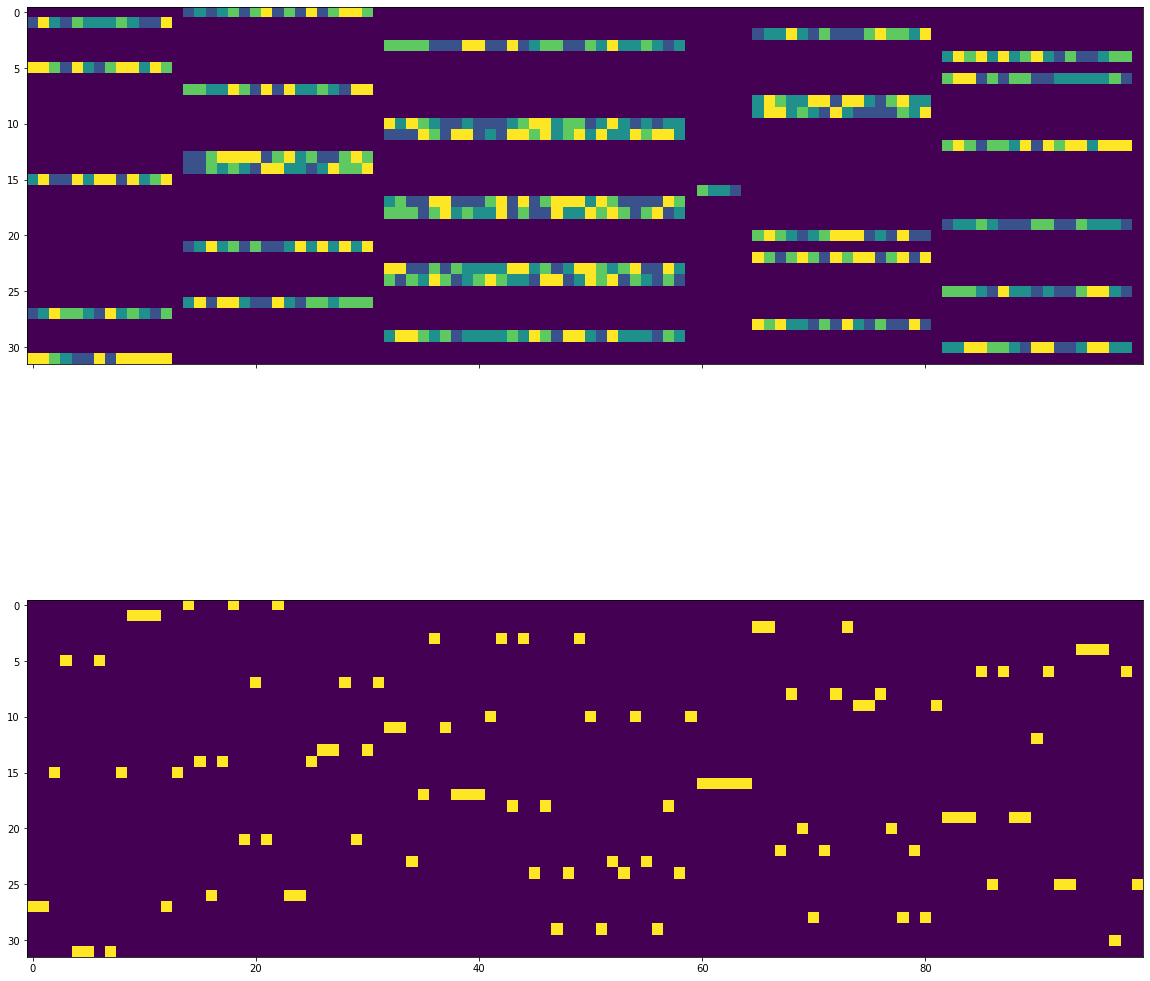

In [14]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(20,20))
ax1.imshow(cib[:,:32].T,interpolation='nearest')
ax2.imshow(assignments[:,:32].T,interpolation='nearest')
plt.savefig("Random block costs weekly schedule",dpi=500)

In [15]:
os = [[] for _ in range(n_blocks)]
gs = [[] for _ in range(n_blocks)]

for b in range(n_blocks):
    for n in range(n_scenarios):
        os[b].append(avg_model.o[b+1,n+1].value)
        gs[b].append(avg_model.g[b+1,n+1].value)

os = np.array(os)
gs = np.array(gs)

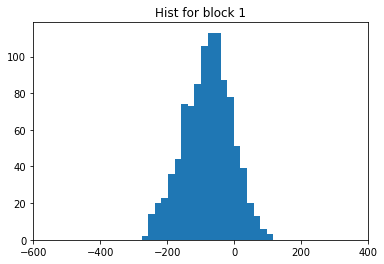

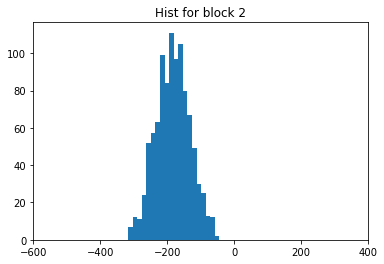

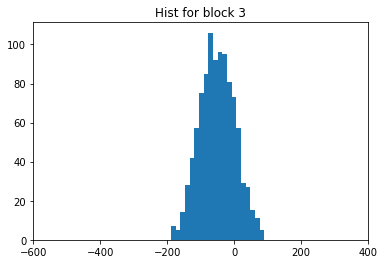

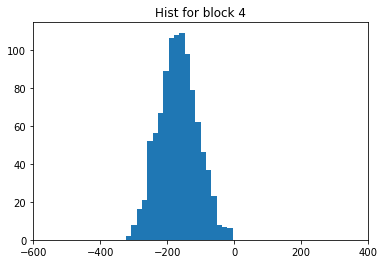

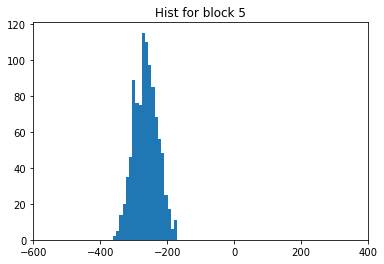

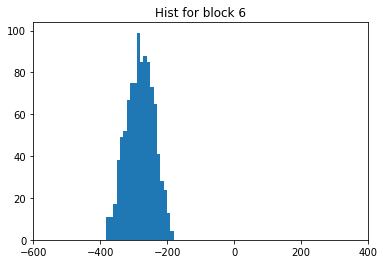

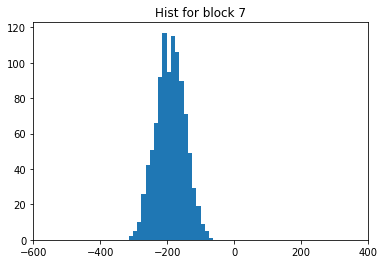

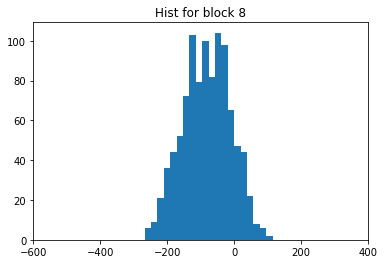

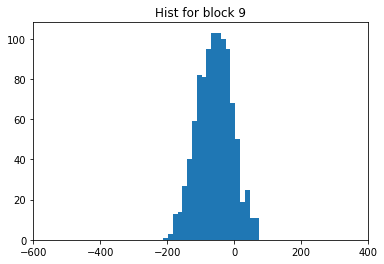

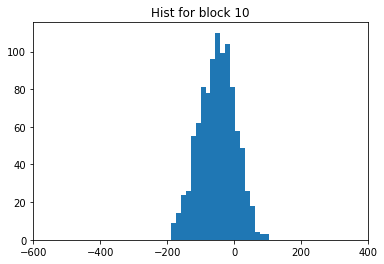

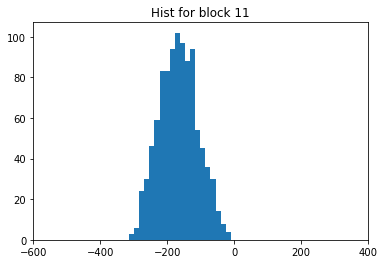

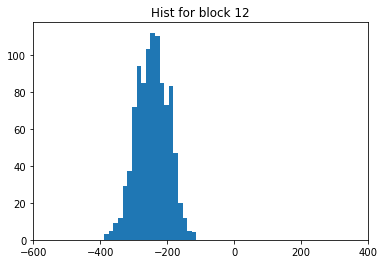

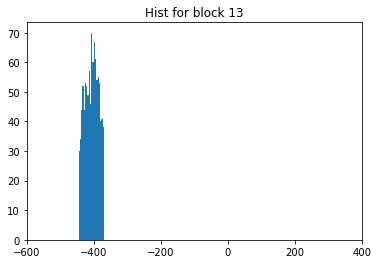

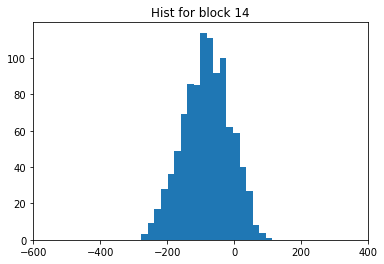

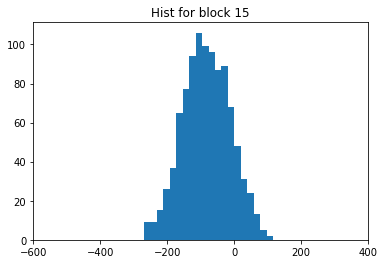

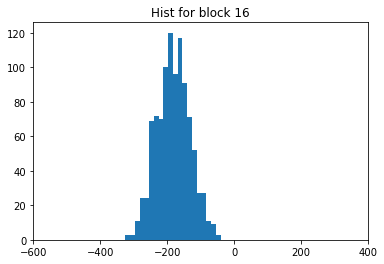

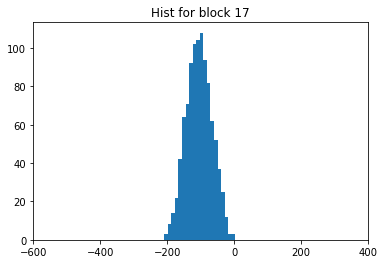

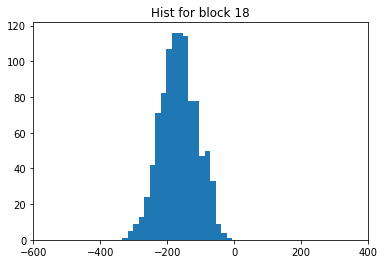

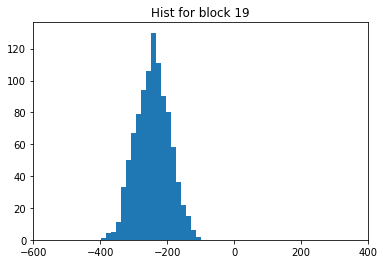

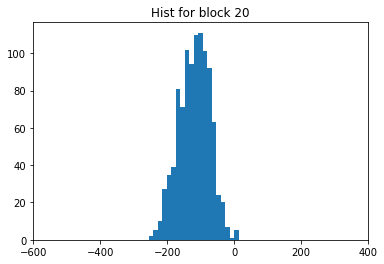

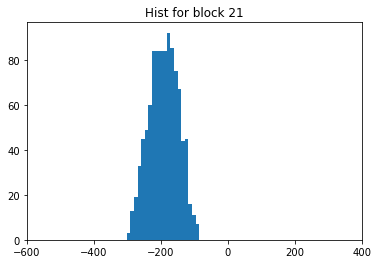

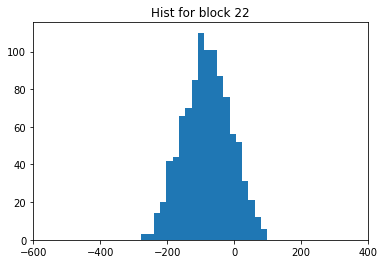

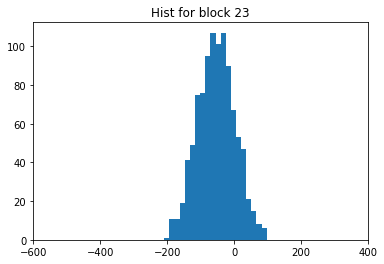

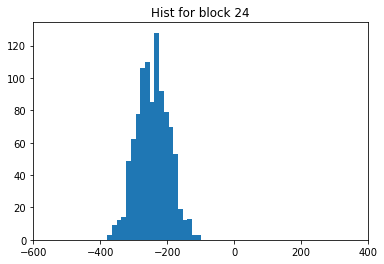

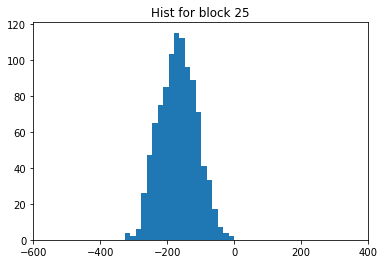

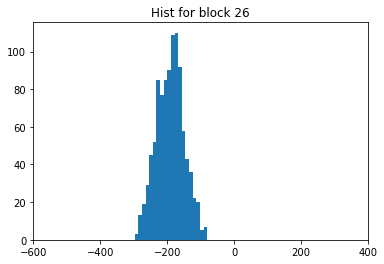

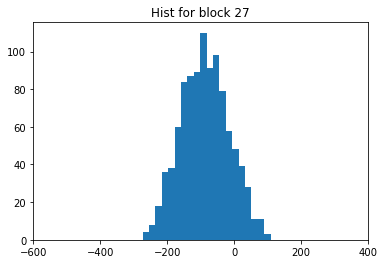

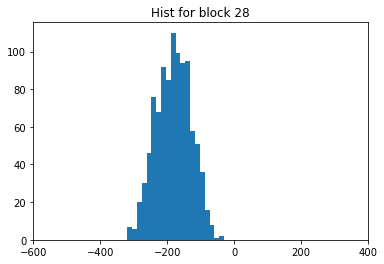

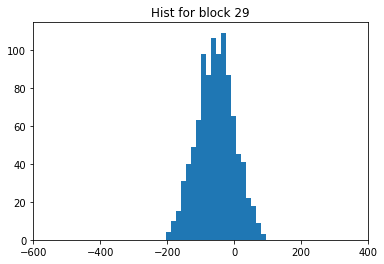

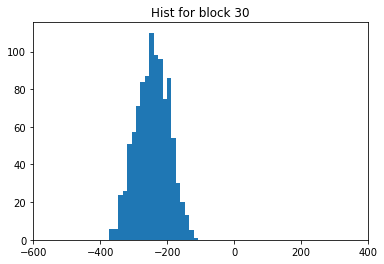

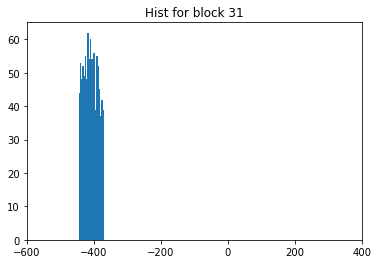

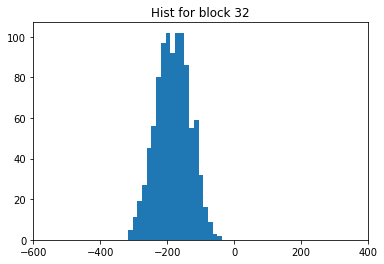

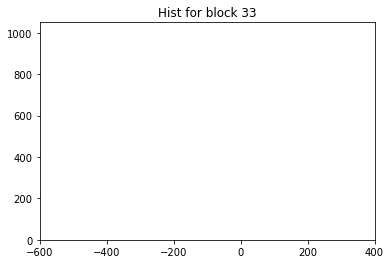

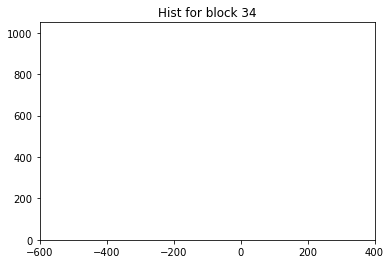

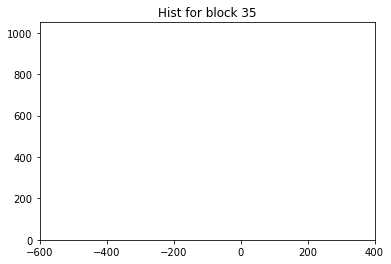

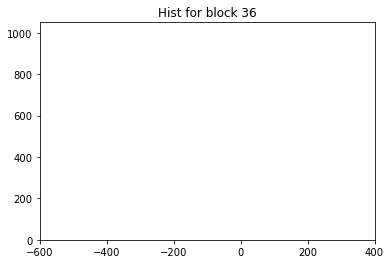

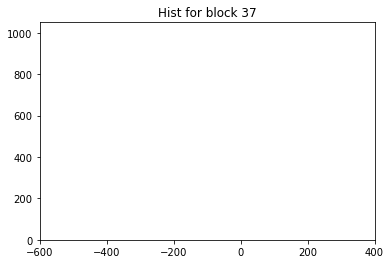

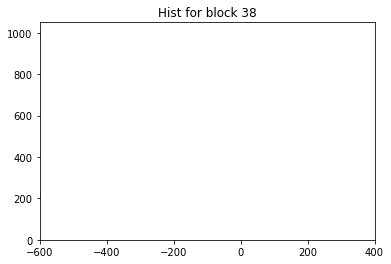

In [16]:
overtime = os-gs

for b in range(n_blocks):
    plt.figure()
    plt.title("Hist for block "+str(b+1))
    plt.hist(overtime[b],bins=20)
    plt.xlim(-600,400)
    plt.show()

In [17]:
cib

array([[   0.,  100.,    0., ...,    0.,    0.,    0.],
       [   0.,  400.,    0., ...,    0.,    0.,    0.],
       [   0.,  200.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0., 1000.],
       [   0.,    0.,    0., ...,    0.,    0., 1000.],
       [   0.,    0.,    0., ...,    0.,    0., 1000.]])

In [18]:
cib[:,33]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.])

In [19]:
cib[9,:]

array([   0.,  200.,    0.,    0.,    0.,  400.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,  400.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        300.,    0.,    0.,    0.,  400., 1000.,    0.,    0.,    0.,
          0.,    0.])

In [20]:
cib[:2,:32]

array([[  0., 100.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 200.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0., 400.],
       [  0., 400.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 200.,   0.,   0.,   0., 400.]])

In [21]:
cib.shape

(100, 38)

In [22]:
overtime[33]

array([-6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
      

In [23]:
cib[14,:]

array([ 100.,    0.,    0.,    0.,    0.,    0.,    0.,  300.,    0.,
          0.,    0.,    0.,    0.,  100.,  100.,    0.,    0.,    0.,
          0.,    0.,    0.,  100.,    0.,    0.,    0.,    0.,  200.,
          0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,
          0.,    0.])

In [24]:
overtime[33]

array([-6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
       -6000., -6000., -6000., -6000., -6000., -6000., -6000., -6000.,
      

<Figure size 720x432 with 0 Axes>

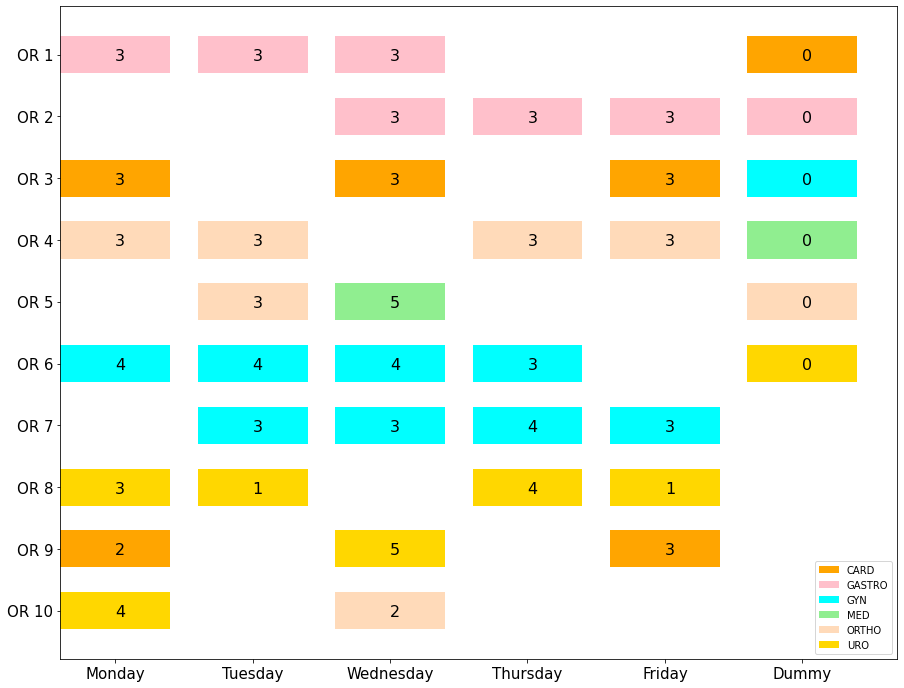

In [25]:
colors = ['orange','pink','cyan','lightgreen','peachpuff','gold']
plt.figure(figsize=(10,6))
j = 0
gastro_y = [1,1,1,2,2,2,2]
gastro_x = [1,2,3,3,4,5,6]
card_y = [3,9,3,3,9,1]
card_x = [1,1,3,5,5,6]
gyn_y = [6,6,7,6,7,6,7,7,3]
gyn_x = [1,2,2,3,3,4,4,5,6]
med_y = [5,4]
med_x = [3,6]
ortho_y = [4,4,5,10,4,4,5]
ortho_x = [1,2,2,3,4,5,6]
uro_y = [8,10,8,9,8,8,6]
uro_x = [1,1,2,3,4,5,6]

barh_blocks = {'GASTRO':[gastro_y,gastro_x],'CARD':[card_y,card_x],'GYN':[gyn_y,gyn_x],'MED':[med_y,med_x],'ORTHO':[ortho_y,ortho_x],'URO':[uro_y,uro_x]}
barh_colors = {}
for i in range(len(specs)):
    barh_colors[specs[i]] = colors[i]

fig,ax = plt.subplots(figsize=(15,12))
j,k = 0,0
for i in specs:
    for m in range(len(blocks[i])):
        text =int(np.round(sum(avg_model.y[idx+1,blocks[i][m]].value for idx in range(n_surgeries))))
        ax.barh(y=11-barh_blocks[i][0][m],width=0.8,height=0.6,left=barh_blocks[i][1][m]-0.4,align='center',color=barh_colors[i],label=i)
        ax.text(barh_blocks[i][1][m], 11-barh_blocks[i][0][m]-0.02, text, color = 'black', ha = 'left', va = 'center',size=16)
    j += 1
#ax.set_yticks([i for i in range(11)],[' ']+['OR '+str(10-i) for i in range(10)])
ax.set_xticks([1,2,3,4,5,6]) # values
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Dummy'],size=15)
ax.set_yticks([i for i in range(1,11)])
ax.set_yticklabels(['OR '+str(10-i) for i in range(10)],size=15)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()